In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt


# LUCAS 2022 data preprocessing to create EO4BK Nomenclature crop classes
## Table of content  

1. [Load data](#1-load-data)
2. [Reduce and Split](#2-reduce-and-split)
3. [Create Class for data with a low detail level](#3-create-class-for-data-with-a-low-detail-level)
4. [Create Class for data with a high detail level](#4-Create-class-for-data-with-a-high-detail-level)
5. [Create Function to merge low detail level and high detail level](#5-create-function-to-merge-low-detail-level-and-high-detail-level)
6. [Create final EO4BKxLUCAS dataset](#6-create-final-eo4bkxlucas-dataset)


# 1. Load data 

In [2]:
lcs2022 = gpd.read_file('/net/projects/EO4BK/WP1/P1-EO4BK/data/LUCAS_Copernicus/l2022_survey_cop_radpoly_attr.gpkg')
# Defind data type if needed 
lcs2022['survey_lc1_perc'] = pd.to_numeric(lcs2022['survey_lc1_perc'])
lcs2022['survey_lc1'] = lcs2022['survey_lc1'].astype(str)
lcs2022['survey_lu1'] = lcs2022['survey_lu1'].astype(str)
lcs2022['survey_lc2'] = lcs2022['survey_lc2'].astype(str)
lcs2022['survey_lu2'] = lcs2022['survey_lu2'].astype(str)
lcs2022['surveycprnlc'] = lcs2022['surveycprnlc'].astype(str)
lcs2022['survey_calc_dist'] = pd.to_numeric(lcs2022['survey_calc_dist'])
lcs2022['nuts0'] = lcs2022['nuts0'].astype(str) 
lcs2022['nuts1'] = lcs2022['nuts1'].astype(str) 
lcs2022['nuts2'] = lcs2022['nuts2'].astype(str) 
lcs2022['nuts3'] = lcs2022['nuts3'].astype(str) 

# 2. Reduce and Split 

From lc2022 only data with U111 'Agriculture (excluding fallow land and kitchen gardens)' == True is used. This subset is further divided into LUCAS Copernicus module (lcscpncs) and LUCAS theoretical points (lcstheo). 
Check whether the lcstheo and lcscpncs spatially agrees (Yes/No). If "No": ld_data, if "Yes": Check if lcstheo and lcspncs LC agrees (Yes/No). If "No": Remove data, if "Yes": hd_data. 

In [3]:
# only U111
lcs2022_u111 = lcs2022[(lcs2022['survey_lu1'].str.slice(0,4) == 'U111') | (lcs2022['survey_lu2'].str.slice(0,4) == 'U111') | (lcs2022['lu1_code'] == 'U111')]

# Coordinates from lcs2022 that belongs to lucastheo
lcstheo = pd.DataFrame(index = lcs2022_u111.index)
lcstheo['lon'] = lcs2022_u111['point_long']
lcstheo['lat'] = lcs2022_u111['point_lat']

# the lucas theoretical points are in EPSGG:4326, while the polygons are in EPSG:3035 # https://ec.europa.eu/eurostat/documents/205002/13686460/C1-LUCAS-2022.pdf
lcstheo = gpd.GeoSeries(gpd.points_from_xy(lcstheo.lon, lcstheo.lat, crs = "EPSG:4326")) 
# change to EPSG: 3035
lcstheo = lcstheo.to_crs(lcs2022_u111.crs) 

# Create Subset of data that spatially agrees == No
spatially_agree_boolean = lcstheo.within(lcs2022_u111.geometry, align = False)
spatially_agree_boolean.index = lcs2022_u111.index
lcs2022_ld_data = lcs2022_u111[spatially_agree_boolean == False]

# Create Subset of data that spatially agrees == Yes
spatially_agree_boolean = lcstheo.within(lcs2022_u111.geometry, align = False)
spatially_agree_boolean.index = lcs2022_u111.index
spatially_agree = lcs2022_u111[spatially_agree_boolean]

# Check from spatially agrees == Yes, whether LC between lcstheo and lcscpncs agree or dont agree? 

## LC agrees == No
error_data = spatially_agree[(spatially_agree['survey_lc1'].str.slice(0,3) != spatially_agree['surveycprnlc'])&(spatially_agree['survey_lc2'].str.slice(0,3) != spatially_agree['surveycprnlc'])]

## LC agrees == Yes
lcs2022_hd_data = spatially_agree[(spatially_agree['survey_lc1'].str.slice(0,3) == spatially_agree['surveycprnlc'])|(spatially_agree['survey_lc2'].str.slice(0,3) == spatially_agree['surveycprnlc'])]



In [4]:
error_data

,point_id,user_id,point_nuts0,pi_extension,point_ex_ante,point_lat,point_long,point_altitude,point_copernicus,point_grassland,...,lu1_code,poly_area_sqm,surveycprncando,surveycprnlc1n,surveycprnclc1e,surveycprnclc1w,surveycprnclc1s,surveycprnlc,col_hex,geometry
64,42523668,DKSU003,DK,0,0,56.11105,8.891669,50,1,0,...,U111,6043.693236,1,35,51,35,51,B23,d8b56b,"POLYGON ((4251975.805 3667974.352, 4251975.145..."
65,43343554,DKSU007,DK,0,0,55.09115,10.203520,10,1,0,...,U111,1331.079017,1,15,18,30,15,C22,00a600,"POLYGON ((4334016.994 3554008.136, 4334019.079..."
155,42223720,DKSU003,DK,0,0,56.57323,8.390622,23,1,0,...,U111,256.166899,1,6,3,16,4,E30,ccf24d,"POLYGON ((4222002.669 3719998.506, 4222003.326..."
387,50784628,FISU104,FI,0,0,63.99628,25.531130,124,1,0,...,U111,4654.196888,1,51,19,51,18,E20,00af49,"POLYGON ((5077957.402 4628028.346, 5077957.624..."
394,53404502,FISU002,FI,0,0,62.31180,29.876480,80,1,1,...,U111,4321.502521,1,20,51,21,45,E10,ccf24d,"POLYGON ((5339990.408 4501981.083, 5339990.247..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137585,46942996,CZSU004,CZ,0,0,49.95741,15.202340,397,1,0,...,U111,8208.527405,1,51,51,51,51,B11,ff2626,"POLYGON ((4693962.07 2996033.631, 4693962.16 2..."
137602,47882924,CZSU006,CZ,0,0,49.24545,16.421670,322,1,0,...,U111,3408.942760,1,16,15,35,51,B11,dda50a,"POLYGON ((4787976.53 2923974.408, 4787976.092 ..."
137637,43282802,DESU030,DE,0,0,48.33146,10.094370,522,1,0,...,U111,32.139338,1,3,3,2,4,A22,cc4df2,"POLYGON ((4327997.181 2802001.78, 4327997.18 2..."
137862,44642792,DESU030,DE,0,0,48.22476,11.923960,511,1,0,...,U111,2491.194137,1,10,11,18,51,E20,ffa5e2,"POLYGON ((4463986.956 2791987.464, 4463986.934..."


# 3 Create Class for data with a low detail level


In [10]:
class lowdetail:

    def __init__(self, ld_data, eo4bkclass, **kwargs):
        
        self.ld_data = ld_data 
        self.eo4bkclass = eo4bkclass
        lc1 = kwargs.get('lc1')
        lc2 = kwargs.get('lc2')
        lc3 = kwargs.get('lc3')



        self.class_list = [lc for lc in [lc1,lc2,lc3] if lc is not None]

        self.ld_class = self.filter_subset()
        self.ld_gdf = self.create_ld_gdf()
    
    def filter_subset(self):
        ld_class = pd.DataFrame()
        for i in self.class_list:
            filtered_ld_data = self.ld_data[self.ld_data['surveycprnlc'] == i]
            ld_class = pd.concat([ld_class, filtered_ld_data], ignore_index= True)
        return ld_class

    
    def create_ld_gdf(self):
        '''
        Creates GeoDataframe from input LC class, with just these Attributes from the LUCAS dataset, that are collected in the COPERNICUS module
        '''
        ld_gdf = gpd.GeoDataFrame({'point_id': [],
                                    'survey_date': [],
                                    'survey_year': [],
                                    'nuts0' :[], 
                                    'nuts1' :[],
                                    'nuts2' : [],
                                    'nuts3'  : [],
                                    'poly_area_sqm' : [], 
                                    'lc3':[],
                                    'lc_eo4bk': [],
                                    'geometry': []
                                    }, 
                                    crs = self.ld_data.crs)
        
        ld_gdf['point_id']      = self.ld_class['point_id'].astype(str)
        ld_gdf['survey_date']   = pd.to_datetime(self.ld_class['survey_date'])
        ld_gdf['survey_year']   = self.ld_class['survey_year']
        ld_gdf['nuts0']         = self.ld_class['nuts0'].astype(str)
        ld_gdf['nuts1']         = self.ld_class['nuts1'].astype(str)
        ld_gdf['nuts2']         = self.ld_class['nuts2'].astype(str)
        ld_gdf['nuts3']         = self.ld_class['nuts3'].astype(str)
        ld_gdf['poly_area_sqm'] = round(self.ld_class['poly_area_sqm'].astype(float), 2)
        ld_gdf['lc3']           = self.ld_class['surveycprnlc']
        ld_gdf['lc_eo4bk']      = self.eo4bkclass
        ld_gdf['geometry']      = self.ld_class.geometry

        return ld_gdf



# 4. Create Class for data with a high detail level

In [11]:
class highdetail:

    def __init__(self, hd_data, eo4bkclass, **kwargs):
        self.hd_data = hd_data
        self.eo4bkclass = eo4bkclass

        lc1 = kwargs.get('lc1')
        lc2 = kwargs.get('lc2')
        lc3 = kwargs.get('lc3')
        lc4 = kwargs.get('lc4')
        lc5 = kwargs.get('lc5')
        lc6 = kwargs.get('lc6')
        lc7 = kwargs.get('lc7')

        lcspec1 = kwargs.get('lcspec1')
        lcspec2 = kwargs.get('lcspec2')

        lc2dbl = kwargs.get('lc2dbl')

        self.class_list = [lc for lc in [lc1,lc2,lc3,lc4,lc5,lc6,lc7] if lc is not None]
        self.class_spec_list = [lc for lc in [lcspec1, lcspec2] if lc is not None]
        
        self.hd_class = self.filter_level3_subset()
        self.hd_spec_class = self.filter_level4_subset()
        self.hd_sglcrp = self.single_cropping()
        self.hd_dblcrp = self.double_cropping(lc2dbl = lc2dbl)

    def filter_level3_subset(self):

        hd_class = pd.DataFrame()
        for i in self.class_list:
            condition1 = (self.hd_data['survey_lc1'].notnull()) & (self.hd_data['survey_lc2'].str.slice(0,3) == i)
            for j in range(0,len(self.class_list)):
                condition2 = (self.hd_data['survey_lc1'].str.slice(0,3) == i) & (self.hd_data['survey_lc2'].str.slice(0,3) == self.class_list[j])
            condition3 = (self.hd_data['survey_lc1'].str.slice(0,3) == i) & (self.hd_data['survey_lc2']  == '8 - Not relevant')

            filtered_hd_data = self.hd_data[condition1|condition2|condition3]
            hd_class = pd.concat([hd_class, filtered_hd_data], ignore_index=True)

        return hd_class

    def filter_level4_subset(self):

        hd_class = pd.DataFrame()
        for i in self.class_spec_list:
            condition1 = (self.hd_data['survey_lc1_spec'].notnull()) & (self.hd_data['survey_lc2_spec'].str.slice(0,4) == i)
            for j in range(0,len(self.class_spec_list)):
                condition2 = (self.hd_data['survey_lc1_spec'].str.slice(0,4) == i) & (self.hd_data['survey_lc2_spec'].str.slice(0,4) == self.class_spec_list[j])
            condition3 = (self.hd_data['survey_lc1_spec'].str.slice(0,4) == i) & (self.hd_data['survey_lc2_spec']  == '8 - Not relevant')

            filtered_hd_data = self.hd_data[condition1|condition2|condition3]
            hd_class = pd.concat([hd_class, filtered_hd_data], ignore_index=True)

        return hd_class
    
    def single_cropping(self):

        sglcrps = pd.DataFrame()
        if self.class_list:
            for i in self.class_list:
                sglcrp = self.hd_class[((self.hd_class['survey_lc1'].str.slice(0,3) == i) & (self.hd_class['survey_lc2'] == '8 - Not relevant'))]
                sglcrps = pd.concat([sglcrps, sglcrp], ignore_index=True)
            return sglcrps
        if self.class_spec_list:
            for i in self.class_spec_list:
                sglcrp = self.hd_spec_class[((self.hd_spec_class['survey_lc1_spec'].str.slice(0,4) == i) & (self.hd_spec_class['survey_lc2_spec'] == '8 - Not relevant'))]
                sglcrps = pd.concat([sglcrps, sglcrp], ignore_index=True)
            return sglcrps

    def double_cropping(self, lc2dbl):

        lc2dbl = str(lc2dbl)
        # dblcrps = pd.DataFrame()
        if self.class_list: 
            dblcrps = self.hd_class[((self.hd_class['survey_lc1'].str.slice(0,3) == self.class_list[0]) & (self.hd_class['survey_lc2'].str.slice(0,3) == lc2dbl))|
                            ((self.hd_class['survey_lc1'].str.slice(0,3) == lc2dbl) & (self.hd_class['survey_lc2'].str.slice(0,3) == self.class_list[0]))]
            return dblcrps
        if self.class_spec_list:
            dblcrps = self.hd_spec_class[((self.hd_spec_class['survey_lc1_spec'].str.slice(0,4) == self.class_spec_list[0]) & (self.hd_spec_class['survey_lc2'].str.slice(0,3) == lc2dbl)) |
                            ((self.hd_spec_class['survey_lc1'].str.slice(0,3) == lc2dbl) & (self.hd_spec_class['survey_lc2'].str.slice(0,4) == self.class_spec_list[0]))]
            return dblcrps


    def create_hd_gdf(self, input_data):

        data = input_data

        hd_gdf = gpd.GeoDataFrame({
            'point_id': [],
            'survey_date': [],
            'survey_year': [],
            'nuts0' :[], 
            'nuts1' :[],
            'nuts2' : [],
            'nuts3'  : [],
            'poly_area_sqm' : [], 
            'lc1' : [],
            'lc2' : [],
            'lc3' : [],
            'lc1_spec':[],
            'lc2_spec':[],
            'lc_eo4bk': [],
            'survey_wm' :[],
            'survey_wm_type':[],
            'survey_wm_source':[],
            'survey_wm_delivery':[],
            'survey_wm_reclaim_signs':[],
            'survey_trees_secondary':[],
            'survey_homplot_fills_extwin':[],
            'survey_parcel_area_ha':[],
            'survey_inspire_arable':[],
            'survey_inspire_plcc1':[],
            'survey_inspire_plcc2':[],
            'survey_inspire_plcc3':[],
            'survey_inspire_plcc4':[],
            'survey_inspire_plcc5':[],
            'survey_inspire_plcc6':[],
            'survey_inspire_plcc7':[],
            'survey_inspire_percon':[],
            'survey_inspire_wetcon':[],
            'survey_inspire_orgcon':[],
            'survey_inspire_checon':[],
            'survey_inspire_intcon':[],
            'survey_inspire_frecon':[],
            'survey_inspire_frecon1':[],
            'survey_inspire_salcon':[],
            'survey_inspire_percon1':[],
            'survey_inspire_unvegetated':[],
            'survey_lm_stone_walls':[],
            'survey_lm_hedge':[],
            'survey_lm_grass_margins':[],
            'survey_lm_grass_hedge':[],
            'survey_lm_stand_veget':[],
            'survey_lm_by_veget':[],
            'survey_lm_crop_resid':[],
            'survey_lm_crop_resid_perc':[],
            'survey_grazing':[],
            'survey_lc_lu_special_remark':[],
            'geometry': []
            }, crs=self.hd_data.crs)

    
        hd_gdf['point_id']                   = data['point_id'].astype(str)
        hd_gdf['survey_date']                = pd.to_datetime(data['survey_date'])
        hd_gdf['survey_year']                = data['survey_year']
        hd_gdf['nuts0']                      = data['nuts0'].astype(str)
        hd_gdf['nuts1']                      = data['nuts1'].astype(str)
        hd_gdf['nuts2']                      = data['nuts2'].astype(str)
        hd_gdf['nuts3']                      = data['nuts3'].astype(str)
        hd_gdf['poly_area_sqm']              = round(data['poly_area_sqm'].astype(float), 2)
        hd_gdf['lc1']                        = data['survey_lc1']
        hd_gdf['lc2']                        = data['survey_lc2']
        hd_gdf['lc3']                        = data['surveycprnlc']  
        hd_gdf['lc1_spec']                   = data['survey_lc1_spec']  
        hd_gdf['lc2_spec']                   = data['survey_lc2_spec']  
        hd_gdf['lc_eo4bk']                   = self.eo4bkclass
        hd_gdf['survey_wm']                  = data['survey_wm']  
        hd_gdf['survey_wm_type']             = data['survey_wm_type']  
        hd_gdf['survey_wm_source']           = data['survey_wm_source']  
        hd_gdf['survey_wm_delivery']         = data['survey_wm_delivery']  
        hd_gdf['survey_wm_reclaim_signs']    = data['survey_wm_reclaim_signs'] 
        hd_gdf['survey_trees_secondary']      = data['survey_trees_secondary']  
        hd_gdf['survey_homplot_fills_extwin'] = data['survey_homplot_fills_extwin']  
        hd_gdf['survey_parcel_area_ha']      = data['survey_parcel_area_ha']  
        hd_gdf['survey_inspire_arable']       = data['survey_inspire_arable']  
        hd_gdf['survey_inspire_plcc1']        = data['survey_inspire_plcc1']  
        hd_gdf['survey_inspire_plcc2']        = data['survey_inspire_plcc2']  
        hd_gdf['survey_inspire_plcc3']        = data['survey_inspire_plcc3']  
        hd_gdf['survey_inspire_plcc4']        = data['survey_inspire_plcc4']  
        hd_gdf['survey_inspire_plcc5']        = data['survey_inspire_plcc5']  
        hd_gdf['survey_inspire_plcc6']        = data['survey_inspire_plcc6']  
        hd_gdf['survey_inspire_plcc7']        = data['survey_inspire_plcc7']  
        hd_gdf['survey_inspire_percon']       = data['survey_inspire_percon']  
        hd_gdf['survey_inspire_wetcon']       = data['survey_inspire_wetcon'] 
        hd_gdf['survey_inspire_orgcon']       = data['survey_inspire_orgcon']  
        hd_gdf['survey_inspire_checon']       = data['survey_inspire_checon']  
        hd_gdf['survey_inspire_intcon']       = data['survey_inspire_intcon']  
        hd_gdf['survey_inspire_frecon']       = data['survey_inspire_frecon']  
        hd_gdf['survey_inspire_frecon1']      = data['survey_inspire_frecon1']  
        hd_gdf['survey_inspire_salcon']       = data['survey_inspire_salcon']  
        hd_gdf['survey_inspire_percon1']      = data['survey_inspire_percon1']  
        hd_gdf['survey_inspire_unvegetated']  = data['survey_inspire_unvegetated']  
        hd_gdf['survey_lm_stone_walls']       = data['survey_lm_stone_walls']  
        hd_gdf['survey_lm_hedge']             = data['survey_lm_hedge'] 
        hd_gdf['survey_lm_grass_margins']     = data['survey_lm_grass_margins']  
        hd_gdf['survey_lm_grass_hedge']       = data['survey_lm_grass_hedge']  
        hd_gdf['survey_lm_stand_veget']       = data['survey_lm_stand_veget']  
        hd_gdf['survey_lm_by_veget']          = data['survey_lm_by_veget']  
        hd_gdf['survey_lm_crop_resid']        = data['survey_lm_crop_resid']  
        hd_gdf['survey_lm_crop_resid_perc']   = data['survey_lm_crop_resid_perc']  
        hd_gdf['survey_grazing']              = data['survey_grazing']  
        hd_gdf['survey_lc_lu_special_remark'] = data['survey_lc_lu_special_remark'] 
        hd_gdf['geometry']                    = data.geometry

        return hd_gdf

        

# 5. Create Function to merge low detail level and high detail level

In [12]:
def merge_gdfs(ld_gdf, hd_gdf):
    eo4bk_gdf = pd.concat([ld_gdf, hd_gdf], ignore_index = True, sort = False)
    return eo4bk_gdf


# 6. Create final EO4BKxLUCAS dataset

In [13]:
#### Cereals

## Wheat

wheat_ld_class = lowdetail(lcs2022_ld_data, eo4bkclass='Wheat', lc1 = 'B11', lc2 = 'B12')
wheat_hd_class = highdetail(lcs2022_hd_data, eo4bkclass='Wheat', lc1 = 'B11', lc2 = 'B12')
wheat_ld = wheat_ld_class.create_ld_gdf()
wheat_hd = wheat_hd_class.create_hd_gdf(wheat_hd_class.hd_sglcrp)

wheat_eo4bk = merge_gdfs(wheat_ld, wheat_hd) 

## Barley 

barley_ld_class = lowdetail(lcs2022_ld_data, eo4bkclass='Barley', lc1 = 'B13')
barley_hd_class = highdetail(lcs2022_hd_data, eo4bkclass='Barley', lc1 = 'B13')
barley_ld = barley_ld_class.create_ld_gdf()
barley_hd = barley_hd_class.create_hd_gdf(barley_hd_class.hd_sglcrp)

barley_eo4bk = merge_gdfs(barley_ld, barley_hd) 

## Oats

oats_ld_class = lowdetail(lcs2022_ld_data, eo4bkclass='Oats', lc1 = 'B15')
oats_hd_class = highdetail(lcs2022_hd_data, eo4bkclass='Oats', lc1 = 'B15')
oats_ld = oats_ld_class.create_ld_gdf()
oats_hd = oats_hd_class.create_hd_gdf(oats_hd_class.hd_sglcrp)

oats_eo4bk = merge_gdfs(oats_ld, oats_hd) 

## Maize 

maize_ld_class = lowdetail(lcs2022_ld_data, eo4bkclass='Maize', lc1 = 'B16')
maize_hd_class = highdetail(lcs2022_hd_data, eo4bkclass='Maize', lc1 = 'B16')
maize_ld = maize_ld_class.create_ld_gdf()
maize_hd = maize_hd_class.create_hd_gdf(maize_hd_class.hd_sglcrp)

maize_eo4bk = merge_gdfs(maize_ld, maize_hd) 

## Rice

rice_ld_class = lowdetail(lcs2022_ld_data, eo4bkclass='Rice', lc1 = 'B17')
rice_hd_class = highdetail(lcs2022_hd_data, eo4bkclass='Rice', lc1 = 'B17')
rice_ld = rice_ld_class.create_ld_gdf()
rice_hd = rice_hd_class.create_hd_gdf(rice_hd_class.hd_sglcrp)

rice_eo4bk = merge_gdfs(rice_ld, rice_hd) 

## Flax 

flax_hd_class = highdetail(lcs2022_hd_data, eo4bkclass='Flax', lcspec1 = 'B35a')
flax_hd = flax_hd_class.create_hd_gdf(flax_hd_class.hd_sglcrp)

flax_eo4bk = flax_hd 

## Other Cereals 

othercereals_ld_class = lowdetail(lcs2022_ld_data, eo4bkclass='Other_cereals', lc1 = 'B19')
othercereals_hd_class = highdetail(lcs2022_hd_data, eo4bkclass='Other_cereals', lc1 = 'B19')
othercereals_ld = othercereals_ld_class.create_ld_gdf()
othercereals_hd = othercereals_hd_class.create_hd_gdf(othercereals_hd_class.hd_sglcrp)

othercereals_eo4bk = merge_gdfs(othercereals_ld, othercereals_hd) 

#### Root Crops 

## Potatoes

potatoes_ld_class = lowdetail(lcs2022_ld_data, eo4bkclass='Potatoes', lc1 = 'B21')
potatoes_hd_class = highdetail(lcs2022_hd_data, eo4bkclass='Potatoes', lc1 = 'B21')
potatoes_ld = potatoes_ld_class.create_ld_gdf()
potatoes_hd = potatoes_hd_class.create_hd_gdf(potatoes_hd_class.hd_sglcrp)

potatoes_eo4bk = merge_gdfs(potatoes_ld, potatoes_hd) 

## Sugar beets

sugarbeetsld_class = lowdetail(lcs2022_ld_data, eo4bkclass='sugar_beets', lc1 = 'B22')
sugarbeetshd_class = highdetail(lcs2022_hd_data, eo4bkclass='sugar_beets', lc1 = 'B22')
sugarbeets_ld = sugarbeetsld_class.create_ld_gdf()
sugarbeets_hd = sugarbeetshd_class.create_hd_gdf(sugarbeetshd_class.hd_sglcrp)

sugarbeets_eo4bk = merge_gdfs(sugarbeets_ld, sugarbeets_hd) 

## Other Root Crops 

otherrootcrops_ld_class = lowdetail(lcs2022_ld_data, eo4bkclass='Other_root_crops', lc1 = 'B23')
otherrootcrops_hd_class = highdetail(lcs2022_hd_data, eo4bkclass='Other_root_crops', lc1 = 'B23')
otherrootcrops_ld = otherrootcrops_ld_class.create_ld_gdf()
otherrootcrops_hd = otherrootcrops_hd_class.create_hd_gdf(otherrootcrops_hd_class.hd_sglcrp)

otherrootcrops_eo4bk = merge_gdfs(otherrootcrops_ld, otherrootcrops_hd) 


### Oil seed

## Sunflowr 

sunflower_ld_class = lowdetail(lcs2022_ld_data, eo4bkclass='Sunflower', lc1 = 'B31')
sunflower_hd_class = highdetail(lcs2022_hd_data, eo4bkclass='Sunflower', lc1 = 'B31')
sunflower_ld = sunflower_ld_class.create_ld_gdf()
sunflower_hd = sunflower_hd_class.create_hd_gdf(sunflower_hd_class.hd_sglcrp)

sunflower_eo4bk = merge_gdfs(sunflower_ld, sunflower_hd) 

## Rapeseed 

rapeseed_ld_class = lowdetail(lcs2022_ld_data, eo4bkclass='Rapeseed', lc1 = 'B32')
rapeseed_hd_class = highdetail(lcs2022_hd_data, eo4bkclass='Rapeseed', lc1 = 'B32')
rapeseed_ld = rapeseed_ld_class.create_ld_gdf()
rapeseed_hd = rapeseed_hd_class.create_hd_gdf(rapeseed_hd_class.hd_sglcrp)

rapeseed_eo4bk = merge_gdfs(rapeseed_ld, rapeseed_hd) 

## Soybean 

soybean_ld_class = lowdetail(lcs2022_ld_data, eo4bkclass='Soybean', lc1 = 'B33')
soybean_hd_class = highdetail(lcs2022_hd_data, eo4bkclass='Soybean', lc1 = 'B33')
soybean_ld = soybean_ld_class.create_ld_gdf()
soybean_hd = soybean_hd_class.create_hd_gdf(soybean_hd_class.hd_sglcrp)

soybean_eo4bk = merge_gdfs(soybean_ld, soybean_hd) 

### Other Crops 

## Cotton 

cotton_ld_class = lowdetail(lcs2022_ld_data, eo4bkclass='Cotton', lc1 = 'B34')
cotton_hd_class = highdetail(lcs2022_hd_data, eo4bkclass='Cotton', lc1 = 'B34')
cotton_ld = cotton_ld_class.create_ld_gdf()
cotton_hd = cotton_hd_class.create_hd_gdf(cotton_hd_class.hd_sglcrp)

cotton_eo4bk = merge_gdfs(cotton_ld, cotton_hd) 

## Sugarcane 

sugarcane_hd_class = highdetail(lcs2022_hd_data, eo4bkclass='Sugarcane', lcspec1 = 'B37e')
sugarcane_hd = sugarcane_hd_class.create_hd_gdf(sugarcane_hd_class.hd_sglcrp)

sugarcane_eo4bk = sugarcane_hd

### Permanent Crops 

## Coffee 

coffee_hd_class = highdetail(lcs2022_hd_data, eo4bkclass='Coffee', lcspec1 = 'B84c')
coffee_hd = coffee_hd_class.create_hd_gdf(coffee_hd_class.hd_sglcrp)

coffee_eo4bk = coffee_hd

## Fruit and Nut Orchards

fruitandnut_ld_class = lowdetail(lcs2022_ld_data, eo4bkclass='Fruit_and_nut', lc1 = 'B71', lc2 = 'B72', lc3 = 'B73', lc4 = 'B74', lc5 = 'B75', lc6 = 'B76', lc7 = 'B77')
fruitandnut_hd_class = highdetail(lcs2022_hd_data, eo4bkclass='Fruit_and_nut', lc1 = 'B71', lc2 = 'B72', lc3 = 'B73', lc4 = 'B74', lc5 = 'B75', lc6 = 'B76', lc7 = 'B77')
fruitandnut_ld = fruitandnut_ld_class.create_ld_gdf()
fruitandnut_hd = fruitandnut_hd_class.create_hd_gdf(fruitandnut_hd_class.hd_sglcrp)

fruitandnut_eo4bk = merge_gdfs(fruitandnut_ld, fruitandnut_hd) 

## Grapes

grapes_ld_class = lowdetail(lcs2022_ld_data, eo4bkclass='Grapes', lc1 = 'B82')
grapes_hd_class = highdetail(lcs2022_hd_data, eo4bkclass='Grapes', lc1 = 'B82')
grapes_ld = grapes_ld_class.create_ld_gdf()
grapes_hd = grapes_hd_class.create_hd_gdf(grapes_hd_class.hd_sglcrp)

grapes_eo4bk = merge_gdfs(grapes_ld, grapes_hd) 


## Fodder Crops

foddercrops_ld_class = lowdetail(lcs2022_ld_data, eo4bkclass='Fodder_crops', lc1 = 'B53', lc2 = 'B54')
foddercrops_hd_class = highdetail(lcs2022_hd_data, eo4bkclass='Fodder_crops', lc1 = 'B53', lc2 = 'B54')
foddercrops_ld = foddercrops_ld_class.create_ld_gdf()
foddercrops_hd = foddercrops_hd_class.create_hd_gdf(foddercrops_hd_class.hd_sglcrp)

foddercrops_eo4bk = merge_gdfs(foddercrops_ld, foddercrops_hd) 


# Plots for EO4BK LUCAS Meeting 

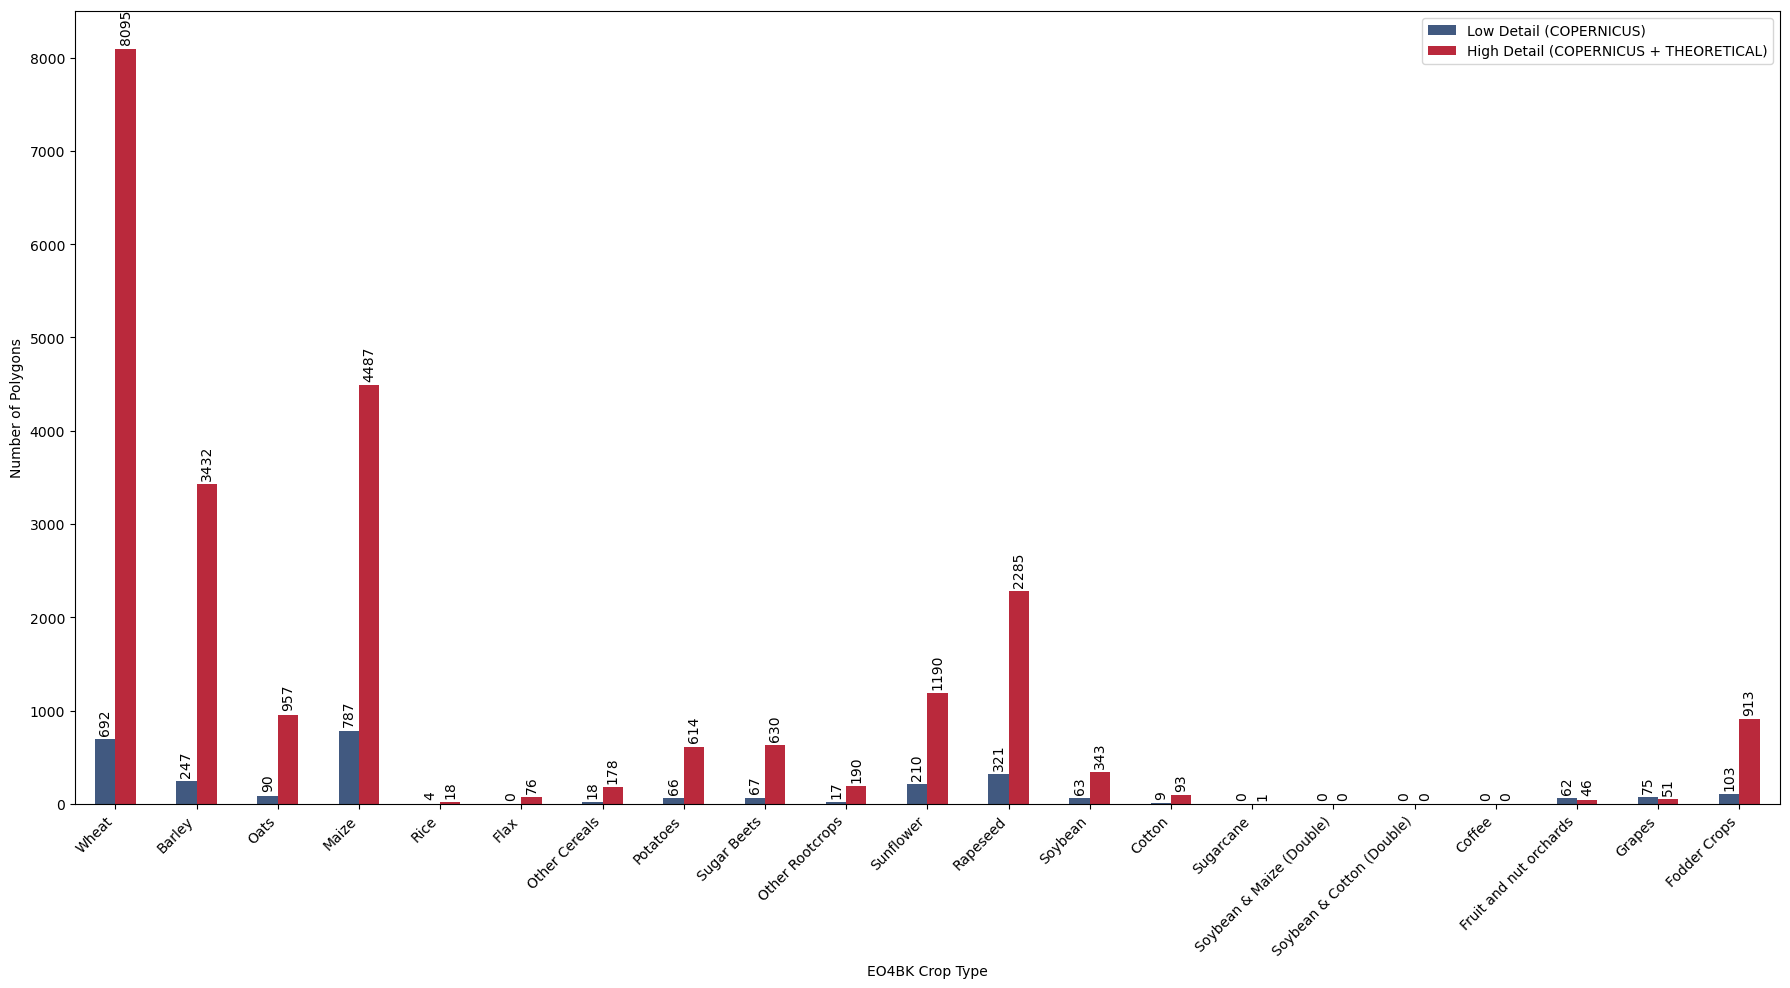

In [145]:
import matplotlib.pyplot as plt

# Assuming you have defined all your dataframes as shown in your code
dataframes = {
    'Wheat': wheat_eo4bk,
    'Barley': barley_eo4bk,
    'Oats': oats_eo4bk,
    'Maize': maize_eo4bk,
    'Rice': rice_eo4bk,
    'Flax': flax_eo4bk,
    'Other Cereals': othercereals_eo4bk,
    'Potatoes': potatoes_eo4bk,
    'Sugar Beets': sugarbeets_eo4bk,
    'Other Rootcrops': otherrootcrops_eo4bk,
    'Sunflower': sunflower_eo4bk,
    'Rapeseed': rapeseed_eo4bk,
    'Soybean': soybean_eo4bk,
    'Cotton': cotton_eo4bk,
    'Sugarcane': sugarcane_eo4bk,
    'Soybean & Maize (Double)': coffee_eo4bk,
    'Soybean & Cotton (Double)': coffee_eo4bk,
    'Coffee': coffee_eo4bk,
    'Fruit and nut orchards': fruitandnut_eo4bk,
    'Grapes': grapes_eo4bk,
    'Fodder Crops': foddercrops_eo4bk
}

nan_counts = {name: {'Low Detail (COPERNICUS)': df['lc1'].isnull().sum(), 'High Detail (COPERNICUS + THEORETICAL)': df['lc1'].notnull().sum()} for name, df in dataframes.items()}

# Convert to a DataFrame for easier plotting
nan_counts_df = pd.DataFrame(nan_counts).T



# Plotting
colors = ['#415980', '#ba293c']

ax = nan_counts_df.plot(kind='bar', figsize=(18, 10), color = colors)
plt.xlabel('EO4BK Crop Type')
plt.ylabel('Number of Polygons')
plt.title('')
plt.xticks(rotation=45, ha='right')

# Add numbers over each bar
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.annotate(f'{height}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", 
                    ha='center', va='bottom', rotation = 90)

plt.tight_layout()

plt.savefig('/net/projects/EO4BK/WP1/P1-EO4BK/scripts/EO4BK-WP1-P1/figures/hist_count.jpg', dpi = 300)

plt.show()

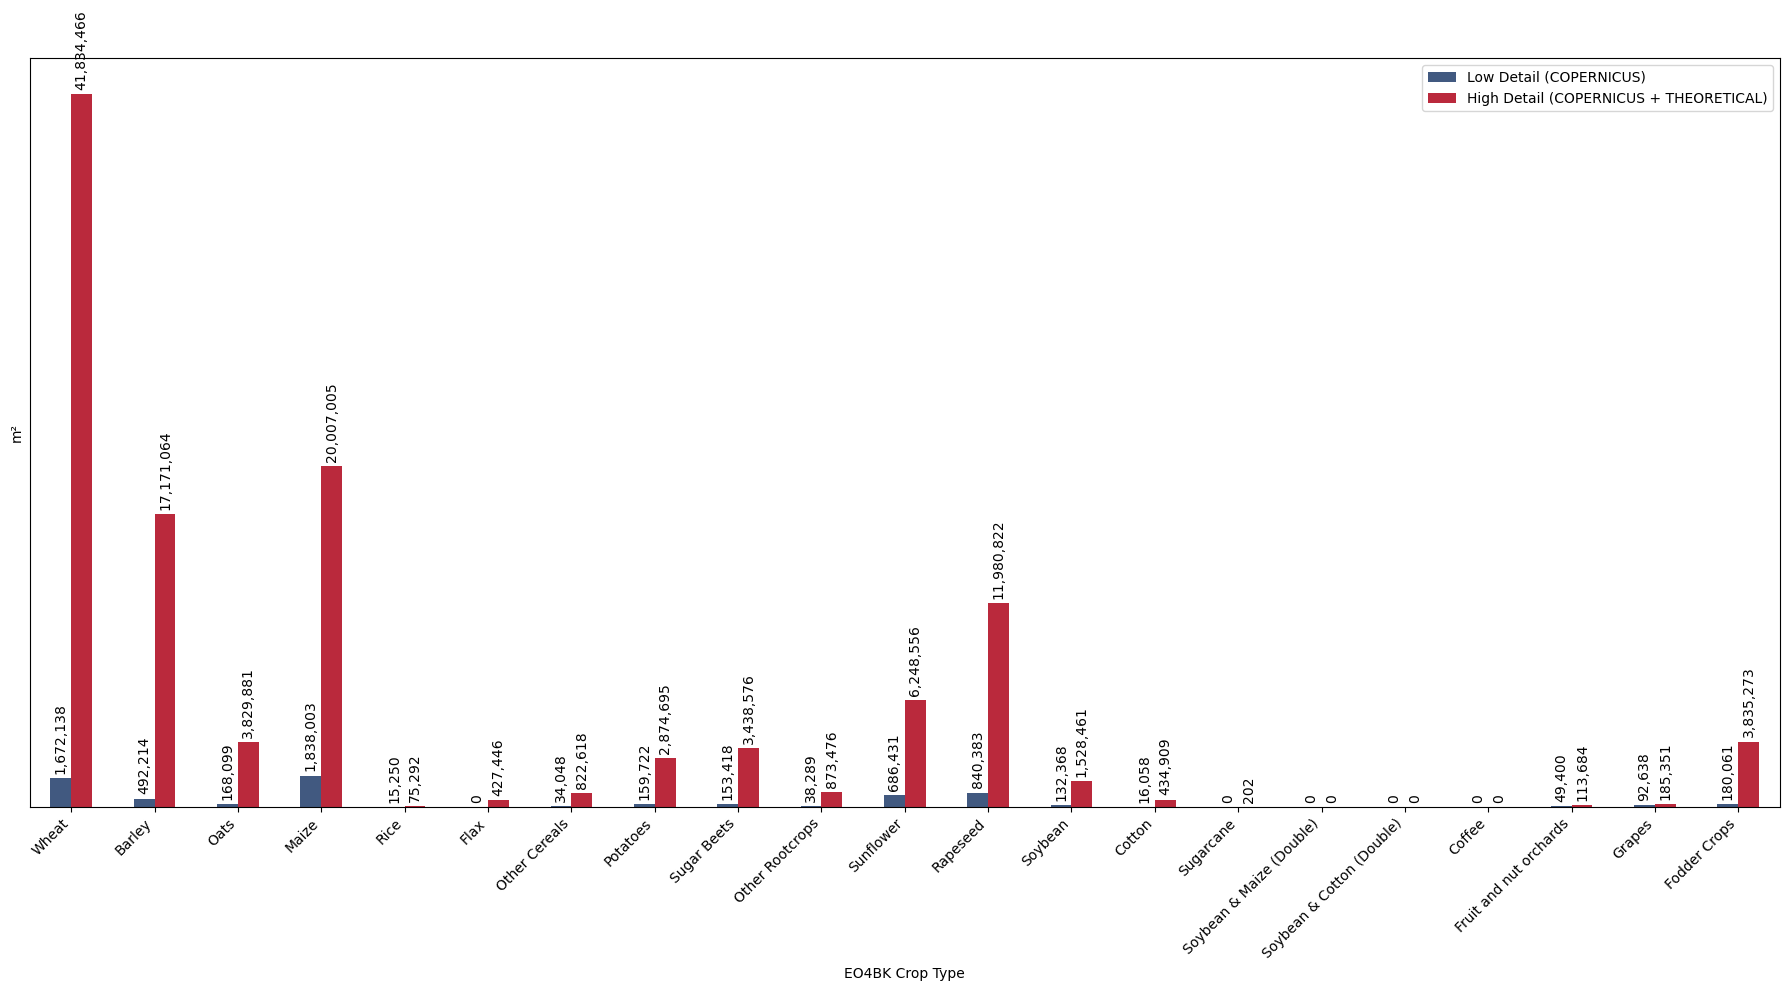

In [152]:

# Assuming your dataframes are defined in the 'dataframes' dictionary as before

# Initialize a dictionary to hold the sums of poly_area_sqm
poly_area_sums = {}

# Iterate over each dataframe to calculate sums
for name, df in dataframes.items():
    sum_nan = df[df['lc1'].isna()]['poly_area_sqm'].sum() 
    sum_not_nan = df[df['lc1'].notna()]['poly_area_sqm'].sum() 
    poly_area_sums[name] = {'Low Detail (COPERNICUS)': sum_nan, 'High Detail (COPERNICUS + THEORETICAL)': sum_not_nan}

# Convert to a DataFrame for easier plotting
poly_area_sums_df = pd.DataFrame(poly_area_sums).T

# Plotting
ax = poly_area_sums_df.plot(kind='bar', figsize=(18, 10), color = colors)
plt.xlabel('EO4BK Crop Type')
plt.ylabel('m²')
plt.title('')
plt.xticks(rotation=45, ha='right')
plt.yticks([])

# Add numbers over each bar
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.annotate(f'{int(height):,}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", 
                    ha='center', va='bottom', rotation = 90)

plt.tight_layout()

plt.savefig('/net/projects/EO4BK/WP1/P1-EO4BK/scripts/EO4BK-WP1-P1/figures/hist_area.jpg', dpi = 300)
plt.show()

In [166]:
import fiona
import geopandas as gpd
europe_nut3 = fiona.open('/net/projects/EO4BK/WP1/P1-EO4BK/data/europe/NUTS_RG_60M_2024_3035.shp',encoding ='iso-8859-1', decoding = 'utf-8') #encoding ='iso-8859-1'
gdf = gpd.GeoDataFrame.from_features([feature for feature in europe_nut3], crs='EPSG:3035')
# Get the order of the fields in the Fiona Collection; add geometry to the end
columns = list(europe_nut3.meta["schema"]["properties"]) + ["geometry"]
# Re-order columns in the correct order
europe_nut3 = gdf[columns]
europe_nut3['nuts3'] = europe_nut3['NUTS_ID']
test = europe_nut3[europe_nut3['NUTS_ID'] != 'ES7']
test = test[test['NUTS_ID'] != 'ES70']
test = test[test['NUTS_ID'] != 'ES']
test = test[test['NUTS_ID'] != 'ES703']
test = test[test['NUTS_ID'] != 'ES704']
test = test[test['NUTS_ID'] != 'ES705']
test = test[test['NUTS_ID'] != 'ES706']
test = test[test['NUTS_ID'] != 'ES707']
test = test[test['NUTS_ID'] != 'ES708']
test = test[test['NUTS_ID'] != 'ES709']
test = test[test['NUTS_ID'] != 'FR']
test = test[test['NUTS_ID'] != 'FRY']
test = test[test['NUTS_ID'] != 'FRY1']
test = test[test['NUTS_ID'] != 'FRY10']
test = test[test['NUTS_ID'] != 'FRY2']
test = test[test['NUTS_ID'] != 'FRY20']
test = test[test['NUTS_ID'] != 'FRY3']
test = test[test['NUTS_ID'] != 'FRY30']
test = test[test['NUTS_ID'] != 'FRY4']
test = test[test['NUTS_ID'] != 'FRY40']
test = test[test['NUTS_ID'] != 'FRY5']
test = test[test['NUTS_ID'] != 'FRY50']
test = test[test['NUTS_ID'] != 'PT2']
test = test[test['NUTS_ID'] != 'PT']
test = test[test['NUTS_ID'] != 'PT20']
test = test[test['NUTS_ID'] != 'PT200']
test = test[test['NUTS_ID'] != 'PT3']
test = test[test['NUTS_ID'] != 'PT30']
test = test[test['NUTS_ID'] != 'PT300']


grapes_df = pd.DataFrame()

# Create DataFrame from counts
grapes_df = grapes_eo4bk['nuts3'].value_counts().reset_index()
grapes_df.columns = ['nuts3', 'count']

fruiandnut_df = pd.DataFrame()

# Create DataFrame from counts
fruiandnut_df = fruitandnut_eo4bk['nuts3'].value_counts().reset_index()
fruiandnut_df.columns = ['nuts3', 'count']


europe_grapes = test.merge(grapes_df, on = 'nuts3', how = 'left')
europe_fruitandnut = test.merge(fruiandnut_df, on = 'nuts3', how = 'left')


/net/home/dschierbaum/.local/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


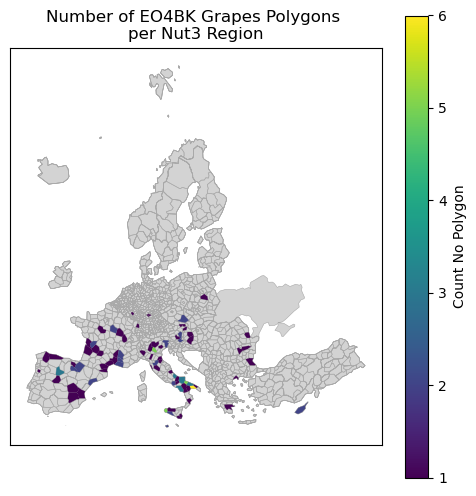

In [183]:
fig, ax = plt.subplots(figsize =(6,6))

EO4BK_class = 'Grapes'

europe_data = europe_grapes

europe_data.plot(column = 'count', missing_kwds={'color': 'lightgrey'}, ax= ax)

test.plot( edgecolor = 'darkgrey', ax = ax, linewidth = 0.4, facecolor = 'none')

europe_data.plot(column = 'count',
                   legend = True, 
                   legend_kwds = {"label":"Count No Polygon"},
                   ax = ax)

ax.set_title(f'Number of EO4BK {EO4BK_class} Polygons \nper Nut3 Region')

# Remove x and y axis labels
ax.set_xticks([])
ax.set_yticks([])

# Optionally, remove ticks as well
ax.tick_params(left=False, bottom=False)

plt.savefig(f'/net/projects/EO4BK/WP1/P1-EO4BK/scripts/EO4BK-WP1-P1/figures/{EO4BK_class}_nut3.jpg', dpi = 300)

# Datacube

1. Create Folder Structure 

In [222]:
import numpy as np
import sentle
from sentle import sentle
from dotenv import load_dotenv
import geopandas as gpd
import pandas as pd
from pathlib import Path
import os
import torch
import xarray as xr
import matplotlib.pyplot as plt
import fiona
import logging
import time
# import rioxarray
from shapely.geometry import mapping 

In [116]:

# Crete Datapath 

datacubepath = '/net/project/EO4BK/WP1/P1-EO4BK/data/Datacube/'

croptype = 'rice'
eo4bkclass = rice_eo4bk

for i in range(0,len(eo4bkclass['nuts0'].unique())):
    for j in range(0, len(eo4bkclass['nuts1'].unique())):
        if list(eo4bkclass['nuts0'].unique())[i] == list(eo4bkclass['nuts1'].unique())[j][:2]:
            dir = f'{datacubepath}/{croptype}/{list(eo4bkclass['nuts0'].unique())[i]}/{list(eo4bkclass['nuts1'].unique())[j]}'
            os.makedirs(dir, exist_ok=True)
            




NameError: name 'net' is not defined

In [87]:
datacubepath

'/net/project/EO4BK/WP1/P1-EO4BK/data/Datacube/'

In [15]:

croptype = 'rice'
eo4bkclass = rice_eo4bk
datacubepath = r'/net/project/EO4BK/WP1/P1-EO4BK/data/Datacube/'


nuts0_list = list(eo4bkclass['nuts0'].unique())
nuts1_list = list(eo4bkclass['nuts1'].unique())

makedonwloadpath = {'path': []}
polygon_list = {'polygon':[]}
for i in range(0, len(nuts0_list)):
    for j in range(0, len(nuts1_list)):
        if list(eo4bkclass['nuts0'].unique())[i] == list(eo4bkclass['nuts1'].unique())[j][:2]:
            path = f"{datacubepath}{croptype}/{nuts0_list[i]}/{nuts1_list[j]}"
            makedonwloadpath['path'].append(path)
            polygon = eo4bkclass[(eo4bkclass['nuts0'] == nuts0_list[i]) & (eo4bkclass['nuts1'] == nuts1_list[j])]
            polygon_list['polygon'].append(polygon)




In [656]:
polygon_list['polygon'][0].iloc[0].geometry.bounds[0]

4349885.734190407

In [672]:
plg = polygon_list['polygon'][4].iloc[0]
plg.geometry.bounds

(3363947.783780176, 2185972.1464218283, 3364005.4190857857, 2186043.6127793496)

In [40]:
import rioxarray as rio
from shapely.geometry import mapping 

In [55]:
makedonwloadpath['path'][0]


'/net/project/EO4BK/WP1/P1-EO4BK/data/Datacube/rice/DE/DE2'

In [83]:

from sentle import sentle
from rasterio.crs import CRS


plg = polygon_list['polygon'][0].iloc[0]     # i iteratates through nuts1 regions and j iterates through the single polygon in nuts1 region of i 
bound_left = int(plg.geometry.bounds[0])
bound_bottom = int(plg.geometry.bounds[1])
bound_right = int(plg.geometry.bounds[2])
bound_top = int(plg.geometry.bounds[3])

plg_crs = polygon_list['polygon'][0].crs

# da = sentle.process(target_crs=plg_crs,
#                     bound_left=bound_left,
#                     bound_bottom=bound_bottom,
#                     bound_right=bound_right,
#                     bound_top=bound_top,
#                     datetime="2024-07-15/2024-07-31",
#                     target_resolution=20,
#                     dask_scheduler_port=10012,
#                     dask_dashboard_address='127.0.0.1:37382',
#                     S2_mask_snow=True,
#                     S2_cloud_classification=True,
#                     S2_cloud_classification_device="cpu",
#                     S1_assets=["vv", "vh"],
#                     S2_apply_snow_mask=True,
#                     S2_apply_cloud_mask=True,
#                     time_composite_freq="7d",
#                     # NOTE clemens: this can be set to 40
#                     num_workers=7,
#                 )

da = da.rio.write_crs(plg_crs)
# da_cl = da.rio.clip(plg.geometry.apply(mapping), plg_crs)

da_cl = da.rio.clip([mapping(plg.geometry)], crs=plg_crs)

outputfile = f"{makedonwloadpath['path'][0]}/{croptype}_sentinel_{polygon_list['polygon'][0]['nuts3'][0]}_{polygon_list['polygon'][0].iloc[0]['point_id']}.zarr"
sentle.save_as_zarr(da_cl, path = outputfile)


KeyError: '.zgroup'

In [101]:
outputfile
/net/projects/EO4BK/WP1/P1-EO4BK/data/EO4BK-WP1-P1/datacubepath

'/net/project/EO4BK/WP1/P1-EO4BK/data/Datacube/rice/DE/DE2/rice_sentinel_DE256_43502912.zarr'

In [77]:
polygon_list['polygon'][0].iloc[0]['point_id']

'43502912'

In [66]:
import os
